In [252]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import pandas as pd

import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

import pathlib
import matplotlib.pyplot as plt

In [309]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [255]:
image_shape = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4', input_shape = image_shape+(3,))
])

labels = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
labels = np.array(labels['background'])
labels[:5]

array(['tench', 'goldfish', 'great white shark', 'tiger shark',
       'hammerhead'], dtype=object)

In [63]:
def get_mobilenet_pred(image_path, classifier = classifier):
    img = Image.open(image_path)
    img = np.array(img)/255.0
    result = classifier.predict(img[np.newaxis, ...])
    predicted_label_indices = np.argpartition(result[0], -4)[-4:]
    return labels[predicted_label_indices]

In [67]:
get_mobilenet_pred('per_imgs/dataset_3/cropped/test/neg/5_20-00068-c.png')

array(['crib', 'gasmask', 'apron', 'brassiere'], dtype=object)

---

load input data

---

In [416]:
train_dir = pathlib.Path('per_imgs/dataset_3/cropped/train')
val_dir = pathlib.Path('per_imgs/dataset_3/cropped/val')
test_dir = pathlib.Path('per_imgs/dataset_3/cropped/test_nsw')

In [427]:
train_images_dict = {
    'pos': list(train_dir.glob('pos/*')),
    'neg': list(train_dir.glob('neg/*')),
}

val_images_dict = {
    'pos': list(val_dir.glob('pos/*')),
    'neg': list(val_dir.glob('neg/*')),
}

test_images_dict = {
    'pos': list(test_dir.glob('pos/*')),
    'neg': list(test_dir.glob('neg/*')),
}

labels_dict = {
    'pos': [0, 1],
    'neg': [1, 0]
}

In [431]:
def assign_x_y(images_dict):
    
    X, y = [], []

    for label, images in images_dict.items():
        for image in images:
            img = cv2.imread(str(image))
            resized_img = cv2.resize(img, (224, 224))

            prep_img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
            
            X.append(prep_img)
            y.append(labels_dict[label])
            
            # convert to np array and scale
            
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [432]:
# X_train, y_train = assign_x_y(train_images_dict)
# X_val, y_val = assign_x_y(val_images_dict)
X_test, y_test = assign_x_y(test_images_dict)

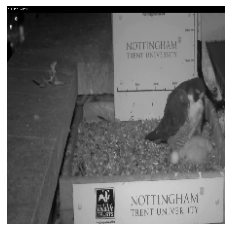

In [409]:
plt.axis('off')
plt.imshow(X_test[1])

In [347]:
pred = classifier.predict(np.array([X_train[0], X_train[1], X_train[2]]))
pred = np.argmax(pred, axis = 1)
pred

array([689, 528, 665])

---

building the model

---

1_3 had added dense layer with no preprocessing except for /255.

In [353]:
t_model_1_4 = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4', input_shape = (224, 224, 3), trainable = False),
    layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(units = 2, activation = 'softmax')
])

In [354]:
t_model_1_4.compile(optimizer=Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [355]:
callback = keras.callbacks.EarlyStopping(monitor='accuracy', min_delta = 0.01, patience=4)

In [356]:
t_model_1_4.fit(X_train, y_train,
                callbacks=[callback], epochs = 10)

Epoch 1/10
52/52 [==============================] - 49s 875ms/step - loss: 0.4870 - accuracy: 0.7920
Epoch 2/10
52/52 [==============================] - 67s 1s/step - loss: 0.2126 - accuracy: 0.9029
Epoch 3/10
52/52 [==============================] - 66s 1s/step - loss: 0.2029 - accuracy: 0.8977
Epoch 4/10
52/52 [==============================] - 63s 1s/step - loss: 0.1685 - accuracy: 0.9253
Epoch 5/10
52/52 [==============================] - 62s 1s/step - loss: 0.1654 - accuracy: 0.9123
Epoch 6/10
52/52 [==============================] - 62s 1s/step - loss: 0.1727 - accuracy: 0.9017
Epoch 7/10
52/52 [==============================] - 58s 1s/step - loss: 0.1658 - accuracy: 0.9141
Epoch 8/10
52/52 [==============================] - 55s 1s/step - loss: 0.1622 - accuracy: 0.9027


In [358]:
t_model_1_4.evaluate(X_val, y_val)

15/15 [==============================] - 16s 907ms/step - loss: 0.4481 - accuracy: 0.8575


[0.44809821248054504, 0.8574513792991638]

In [435]:
t_model_1_4.evaluate(X_test, y_test)

1/1 [==============================] - 1s 810ms/step - loss: 1.4116 - accuracy: 0.5172


[1.4116089344024658, 0.517241358757019]

In [380]:
X_test[0].shape

(224, 224, 3)

In [383]:
X_test[0].shape

(224, 224, 3)

In [400]:
np.argmax(t_model_1_4.predict(X_train[2][np.newaxis, ...]), axis = -1)

array([1])

In [394]:
y_test

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0,

In [377]:
tf.keras.experimental.export_saved_model(t_model_1_4, 't_model_1_4.h5')

AttributeError: module 'tensorflow.keras.experimental' has no attribute 'export_saved_model'

---

try compiling something similar using another method

---

In [369]:
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 4s 0us/step


In [376]:
base_model.trainable = False

# base_model.summary()

feature_batch = base_model(X_train)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)

KeyboardInterrupt: 

In [373]:
feature_batch = base_model(X_test)
feature_batch.shape

TensorShape([136, 7, 7, 1280])

In [90]:
def get_transfer_pred(image_path, classifier = classifier):
    img = Image.open(image_path)
    img = np.array(img)/255.0
    result = classifier.predict(img[np.newaxis, ...])
    return result

def make_plot_predictions(test_batch, model):
    cm_plot_labels = ['neg', 'pos']
    predictions = model.predict(x = test_batch, verbose = 0)
    cm = confusion_matrix(y_true=test_batch.classes, y_pred = np.argmax(predictions, axis = -1))
    return plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')